In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
# Load pre-processed data
Gold_CRC_GE = pd.read_csv("SingaporeCRC_data/MSIde_exp.csv", index_col=0, delimiter=",")
Gold_CRC_GE = Gold_CRC_GE.T

pid = Gold_CRC_GE.index #.astype('float')
Gold_CRC_GE.insert(0,'patient_id',pid)

Gold_CRC_GE

,patient_id,TAC1,SLC13A2,HOXC8,CCDC85A,MSH4,F7,DLX3,MS4A12,RBFOX1,...,PWRN3,CKBP1,LINC01195,UBE2FP2,LINC01177,KRT23,CRAT40,MIR4686,MIR5692C1,RPL23AP77
X1504,X1504,0.150865,0.031442,0.014380,0.117586,0.138560,0.625151,0.416349,0.056656,0.782366,...,2.838393,0.000000,0.682927,0.179771,0.597685,4.591044,1.939303,2.215627,1.411125,0.145117
X1603,X1603,0.911631,0.487500,0.000000,0.122059,0.119816,0.733709,0.016125,1.890287,0.060361,...,0.000000,0.000000,0.307336,0.106024,0.112975,2.776638,0.376516,2.195063,2.820293,0.000000
X1324,X1324,0.066874,1.233493,0.004499,0.036924,0.116298,0.199512,0.039120,0.069026,0.045128,...,0.340978,0.000000,0.237493,0.048902,0.186388,3.292372,1.349458,2.244069,2.372126,0.000000
X834,X834,0.155618,0.398642,0.000000,0.014148,0.071768,0.951181,0.270268,0.282309,0.039839,...,0.017316,0.012916,0.190823,0.000000,0.092336,2.180405,3.597639,1.770618,1.063797,0.038719
X47,X47,0.594452,0.115947,0.038960,0.037877,0.529422,0.018677,0.086426,0.117315,0.139223,...,0.045355,0.011381,0.000000,1.920003,0.000000,0.075379,0.079571,0.000000,0.000000,0.034402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1607,X1607,0.241303,1.934167,0.028354,0.023844,0.264366,0.233425,0.027388,0.590600,0.073154,...,0.000000,0.000000,0.000000,0.061165,0.049218,3.299821,0.859288,1.550284,0.000000,0.119461
X1448,X1448,0.065199,0.558250,0.287339,0.083389,0.241614,0.772533,0.109036,0.994777,0.169361,...,0.583674,0.040260,0.000000,0.000000,0.148300,3.956319,2.734521,2.253486,4.152947,0.063782
X891,X891,0.000000,0.005031,0.012878,0.053363,0.078074,0.727017,0.016893,0.047841,0.048284,...,0.233381,0.000000,0.034051,0.524145,0.000000,2.064755,5.271607,1.970973,0.000000,0.187379
X858,X858,0.000000,0.005289,0.761545,0.067219,1.260629,0.049620,0.016077,0.194538,0.002780,...,0.000000,0.000000,0.000000,0.973396,0.000000,0.030768,0.000000,0.636250,0.000000,0.000000


In [3]:
metadata = pd.read_csv("SingaporeCRC_data/filtered_metadata.csv", index_col=0,delimiter=",")
metadata = metadata.dropna()
metadata = metadata.drop(['SMAD4', 'RNF43'], axis = 1)
metadata

,patient_id,TMB,KRAS,BRAF,NRAS,TP53,APC,PIK3CA,PIK3R1,ERBB4,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
3,X106,1028,wt,wt,wt,wt,wt,wt,wt,wt,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X153,80,mut,wt,wt,mut,mut,mut,wt,wt,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
5,X326,1512,mut,wt,wt,wt,wt,wt,wt,mut,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
7,X420,1976,mut,wt,wt,mut,mut,wt,wt,wt,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
8,X470,739,wt,wt,wt,wt,wt,wt,mut,wt,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,X1658,82,mut,wt,wt,mut,mut,wt,wt,wt,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
143,X1662,74,mut,wt,wt,mut,wt,wt,wt,wt,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
144,X1664,46,mut,wt,wt,mut,wt,wt,wt,wt,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
145,X1665,93,mut,wt,wt,mut,mut,wt,wt,wt,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [4]:
SG_Gold_CRC_GE = pd.merge(Gold_CRC_GE, metadata, on='patient_id', how='inner')
SG_Gold_CRC_GE

,patient_id,TAC1,SLC13A2,HOXC8,CCDC85A,MSH4,F7,DLX3,MS4A12,RBFOX1,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
0,X1504,0.150865,0.031442,0.014380,0.117586,0.138560,0.625151,0.416349,0.056656,0.782366,...,70.0,Rectum,Left,2,T2N1(3/21)M1,IV,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
1,X1603,0.911631,0.487500,0.000000,0.122059,0.119816,0.733709,0.016125,1.890287,0.060361,...,66.0,Rectosigmoid junction,Left,2,T3N0(0/19)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
2,X1324,0.066874,1.233493,0.004499,0.036924,0.116298,0.199512,0.039120,0.069026,0.045128,...,73.0,Sigmoid colon,Left,2,T3N1c(0/17)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
3,X834,0.155618,0.398642,0.000000,0.014148,0.071768,0.951181,0.270268,0.282309,0.039839,...,71.0,Rectosigmoid junction,Left,2,T3N0(0/27)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
4,X1662,0.455670,3.476218,0.004884,0.517283,0.059455,0.197867,0.023521,5.879199,2.342547,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,X1607,0.241303,1.934167,0.028354,0.023844,0.264366,0.233425,0.027388,0.590600,0.073154,...,67.0,Ascending colon,Right,2,T3N1b(2/32)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
107,X1448,0.065199,0.558250,0.287339,0.083389,0.241614,0.772533,0.109036,0.994777,0.169361,...,68.0,Rectum,Left,2,T3N2(4/17)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
108,X891,0.000000,0.005031,0.012878,0.053363,0.078074,0.727017,0.016893,0.047841,0.048284,...,73.0,Splenic flexure,Left,2,T3N1(1/19)M0,IIA,iCMS3,CMS4,iCMS3_MSS,iCMS3_fibrotic
109,X858,0.000000,0.005289,0.761545,0.067219,1.260629,0.049620,0.016077,0.194538,0.002780,...,55.0,Ascending colon,Right,2,T3N0(0/26)M0,IIA,iCMS3,CMS3,iCMS3_MSI,iCMS3_MSI


In [5]:
class_counts = SG_Gold_CRC_GE['MSI.Status'].value_counts()
print(class_counts)

MSI.Status
MSS    87
MSI    24
Name: count, dtype: int64


In [6]:
# Prepare features and target variable
X = SG_Gold_CRC_GE.drop(['patient_id', 'TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'ERBB4', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_Gold_CRC_GE['MSI.Status']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['MSI' 'MSS']
Unique values of y: [0 1]
Shape of y: (111, 269)
Shape of y: (111,)


In [7]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X, y)

print(X_scaled.shape)
print(y.shape)

(174, 269)
(174,)


Best Parameters: {'alpha': 1, 'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.9857142857142858
Test Set Accuracy: 0.9714285714285714


<Figure size 800x600 with 0 Axes>

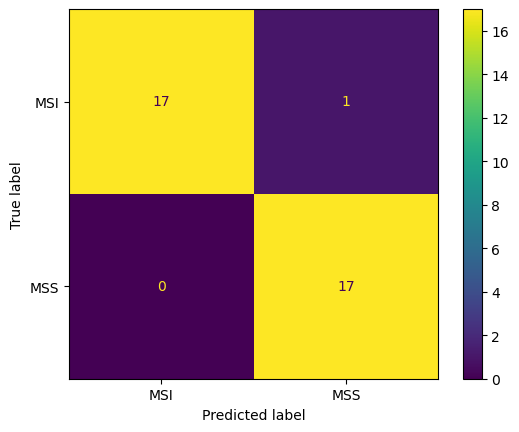

              precision    recall  f1-score   support

         MSI       1.00      0.94      0.97        18
         MSS       0.94      1.00      0.97        17

    accuracy                           0.97        35
   macro avg       0.97      0.97      0.97        35
weighted avg       0.97      0.97      0.97        35



In [21]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1],
    'alpha': [1],
    'colsample_bytree': [0.8],
    'subsample': [0.8, 0.9],
    'n_estimators':[100],
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=cv)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MSI', 'MSS'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['MSI', 'MSS'])
print(report)


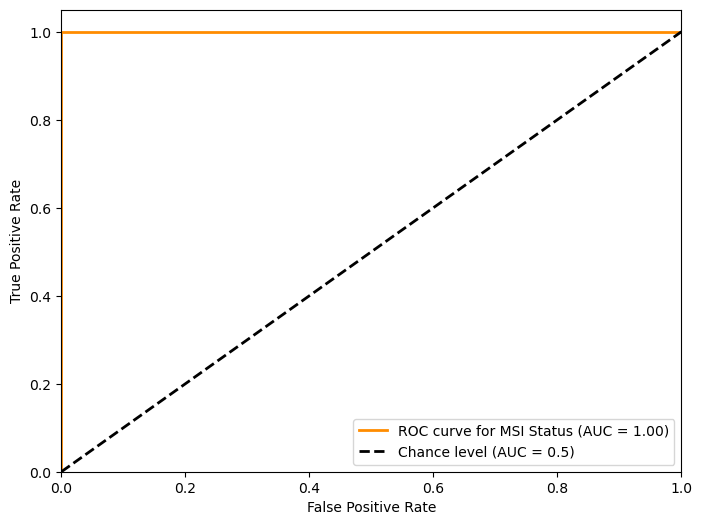

In [22]:
# Predict probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for MSI Status (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_15104\951501840.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


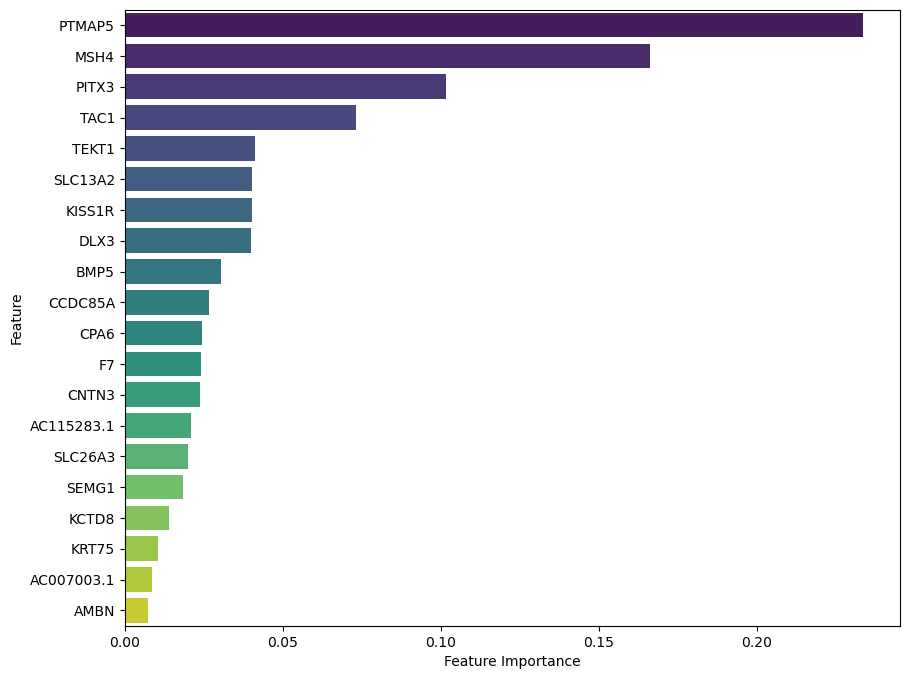

In [23]:
# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

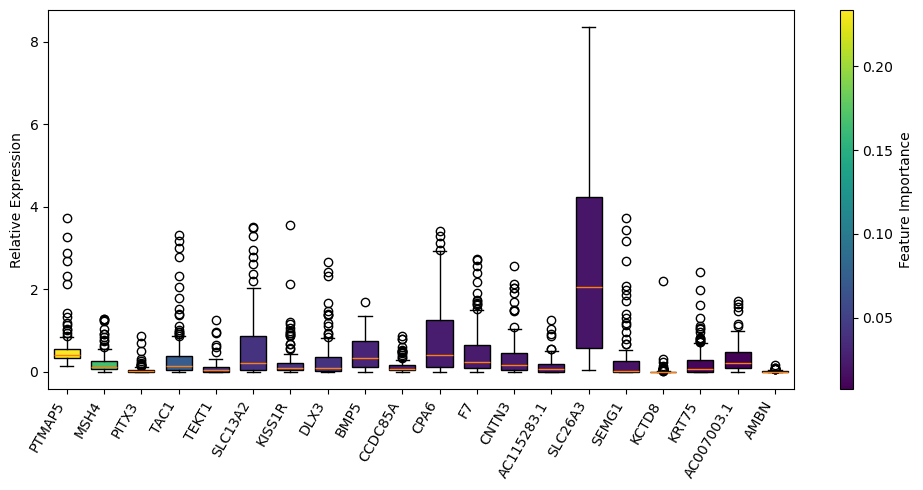

In [24]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

top_20_feature_names = feature_names[top_20_indices]

# Normalize feature importances
norm = Normalize(vmin=min(feature_importances[top_20_indices]), vmax=max(feature_importances[top_20_indices]))
cmap = plt.get_cmap('viridis')  # Choose a colormap
colors = [cmap(norm(importance)) for importance in feature_importances[top_20_indices]]

# Prepare data for boxplot
data = {}

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each box with the corresponding color based on feature importance
for i, (key, value) in enumerate(data.items()):
    box = ax.boxplot(value, positions=[i + 1], widths=0.7, patch_artist=True,
                     boxprops=dict(facecolor=colors[i], color='black'),
                     whiskerprops=dict(color='black'))

# Customize plot
ax.set_ylabel('Relative Expression', fontsize=10)
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar, not for plotting
cbar = plt.colorbar(sm, ax=ax, aspect=30)
cbar.set_label('Feature Importance', fontsize=10)

plt.show()

In [8]:
#Evaluate the robustness of ML framework

from sklearn.metrics import precision_score, recall_score, f1_score

# Define parameters for XGB model
params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1],
    'alpha': [1], # Include L1 regularization
    'colsample_bytree': [0.8],
    'subsample': [0.8, 0.9],
    'n_estimators':[100],
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Robustness test
n_iterations = 20
robustness_train_scores = []
robustness_test_scores = []
robustness_auroc = []
precision_scores = []
recall_scores = []
f1_scores = []
important_features = []

for i in range(n_iterations):
    # Split the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=i, stratify=y)

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=cv)
    grid_search.fit(X_train, y_train)

    # Evaluate the model on the training data of the resampled set
    train_score = grid_search.best_score_
    robustness_train_scores.append(train_score)

    # Evaluate the model on the test data of the resampled set
    y_pred = grid_search.best_estimator_.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    robustness_test_scores.append(test_score)
    
    # Calculate AUROC score
    y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, y_test_proba)
    robustness_auroc.append(test_auroc)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Extract the best model's parameters and feature importances
    best_params = grid_search.best_params_
    best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
    best_xgb_model.fit(X_train, y_train)

    feature_importances = best_xgb_model.feature_importances_
    top_20_indices = feature_importances.argsort()[::-1][:20]
    feature_names = X.columns
    top_20_features = feature_names[top_20_indices]
    important_features.extend(top_20_features)

# Calculate statistics for training data
robustness_train_mean = np.mean(robustness_train_scores)
robustness_train_std = np.std(robustness_train_scores)

# Calculate statistics for test data
robustness_test_mean = np.mean(robustness_test_scores)
robustness_test_std = np.std(robustness_test_scores)

# Calculate statistics for AUROC
robustness_auroc_mean = np.mean(robustness_auroc)
robustness_auroc_std = np.std(robustness_auroc)

# Calculate mean and standard deviation for precision, recall, and F1 score
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Train Mean Accuracy:", robustness_train_mean)
print("Train Std Accuracy:", robustness_train_std)
print("Test Mean Accuracy:", robustness_test_mean)
print("Test Std Accuracy:", robustness_test_std)
print("Mean AUROC:", robustness_auroc_mean)
print("Std AUROC:", robustness_auroc_std)
print("Mean Precision:", mean_precision)
print("Std Precision:", std_precision)
print("Mean Recall:", mean_recall)
print("Std Recall:", std_recall)
print("Mean F1 Score:", mean_f1)
print("Std F1 Score:", std_f1)


Train Mean Accuracy: 0.9835317460317462
Train Std Accuracy: 0.009043934318834008
Test Mean Accuracy: 0.9828571428571429
Test Std Accuracy: 0.024578072191550372
Mean AUROC: 0.9998366013071894
Std AUROC: 0.0007122383894674278
Mean Precision: 0.9796528084918178
Std Precision: 0.03945147211279712
Mean Recall: 0.988562091503268
Std Recall: 0.02288748535280148
Mean F1 Score: 0.9835060936608924
Std F1 Score: 0.023149858140395302


In [9]:
print(f"Train_accuracy_scores: {robustness_train_scores}" )
print(f"Test_accuracy_scores: {robustness_test_scores}" )
print(f"AUROC_scores: {robustness_auroc}" )
print(f"precision_scores: {precision_scores}" )
print(f"recall_scores: {recall_scores}" )
print(f"f1_scores: {f1_scores}" )

Train_accuracy_scores: [0.9783068783068783, 0.9857142857142858, 1.0, 0.9928571428571429, 0.9857142857142858, 0.9785714285714284, 0.9928571428571429, 0.9857142857142858, 0.9785714285714284, 0.9785714285714284, 0.9785714285714286, 0.9928571428571429, 0.9857142857142858, 0.9925925925925926, 0.9785714285714286, 0.9642857142857142, 0.9642857142857142, 0.9785714285714284, 0.9925925925925926, 0.9857142857142858]
Test_accuracy_scores: [1.0, 0.9714285714285714, 0.9714285714285714, 1.0, 0.9428571428571428, 1.0, 1.0, 1.0, 0.9142857142857143, 1.0, 0.9714285714285714, 0.9714285714285714, 0.9428571428571428, 1.0, 1.0, 1.0, 1.0, 0.9714285714285714, 1.0, 1.0]
AUROC_scores: [1.0, 1.0, 1.0, 1.0, 0.9967320261437909, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision_scores: [1.0, 0.9473684210526315, 1.0, 1.0, 0.9411764705882353, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.9473684210526315, 1.0, 1.0]
recall_scores: [1.0, 1.0, 0.94117647058

In [10]:
# Print or process the list of important features
print("Total number of selected features:", len(important_features))
important_features = pd.DataFrame(important_features)
important_features.to_csv('FI_XGB_SGGE_MSI.csv', index=False)

Total number of selected features: 400
